<a href="https://colab.research.google.com/github/hiwoooo/DataScience_pjt/blob/master/%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 프로젝트 개요
- 프로젝트 기획 배경 및 목표

  수업시간에 다양한 알고리즘을 만들어보며 각자 구현해보는 시간이 부족했다 판단하였고, 새로운 아이디어로 결과물을 만들어 내기보단 데이터 전처리와 파라미터를 튜닝하며 실제 적용하며 알고리즘 구현 연습하는 것에 초점을 맞췄습니다. 주어진 데이터만을 활용하여 프로젝트를 진행할 수 있는 데이콘 경진대회에 참여하기로 하였고, 그중 수업시간에 했던 실습 예제와 비슷해 접근하기 쉬운 ‘신용카드 사용자 연체 예측 AI’ 주제로 선정하였습니다. 

  본 대회의 목표는 신용카드 사용자의 개인 신상정보 데이터로 신용자의 신용카드 대금 연체 정도를 예측하는 인공지능 알고리즘을 개발입니다. 저희 조는  LogLoss 0.67626 이하의 알고리즘을 구현하여 데이콘 대회 PUBLIC 100위 안에 드는 것을 목표로 하였습니다.



# 프로세싱

- 라이브러리

In [38]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import os, glob, warnings
from itertools import combinations

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_selection import VarianceThreshold

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import log_loss
from category_encoders.ordinal import OrdinalEncoder

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

from sklearn.preprocessing import StandardScaler
import multiprocessing
import random
import optuna
from optuna.samplers import TPESampler

In [ ]:
!pip install category_encoders
!pip install catboost

In [6]:
import tensorflow as tf

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# ML
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# ensemble(bagging)
from sklearn.ensemble import ( 
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
)

#ensemble(boosting)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

#stacking
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, StackingRegressor

# 평가
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report

# 교차검증
from sklearn.model_selection import (
  KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, train_test_split
)

# Feature Selection
from sklearn.feature_selection import RFE, RFECV
from category_encoders.ordinal import OrdinalEncoder

## 데이터 업로드

In [7]:
train=pd.read_csv('/content/drive/MyDrive/data/pjt/train.csv')
test=pd.read_csv('/content/drive/MyDrive/data/pjt/test.csv')
sample_sub=pd.read_csv('/content/drive/MyDrive/data/pjt/sample_submission.csv')

print(train.shape)
print(test.shape)

(26457, 20)
(10000, 19)


In [8]:
train.head(2)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


In [9]:
test.head(2)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0


## 결측치처리

- income_type == Pensinoer & DAYS_EMPLOYED == 0
  - 퇴직 후 연금수령자 (retiree)
- income_type == Pensinoer & DAYS_EMPLOYED > 0
  - n연금형태의 지원금(?)을 받고 있는 근로자, 미기재 (No response)
- income_type != Pensinoer & DAYS_EMPLOYED > 0
  - 미기재 (No response)
- income_type != Pensinoer & DAYS_EMPLOYED == 0
  - 없음

In [10]:
train.loc[ (train.occyp_type.isna() == True) & (train.DAYS_EMPLOYED > 0) & (train.income_type == 'Pensioner') , 'occyp_type' ] = 'retiree'
train['DAYS_EMPLOYED'] = train[ 'DAYS_EMPLOYED' ].map(lambda x: 0 if x>0 else x)
train.fillna('No response', inplace=True) 

test.loc[ (test.occyp_type.isna() == True) & (test.DAYS_EMPLOYED > 0) & (test.income_type == 'Pensioner') , 'occyp_type' ] = 'retiree'
test['DAYS_EMPLOYED'] = test[ 'DAYS_EMPLOYED' ].map(lambda x: 0 if x>0 else x)
test.fillna('No response', inplace=True)

## 이상치 처리
- train 의 family_size 이상치 제거
  - 값이 9 이상인 인덱스 제거 (child_num의 이상치와 상응한다)
- test 엔 값이 9인 인덱스 없음

In [11]:
train = train[ ( train['family_size'] <= 7 ) ]
train = train.reset_index(drop=True)

## 음수값, 양수로 변환 후 log
- 너무 큰 값을 갖는 변수 log 취해준다

In [12]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])
    df['DAYS_EMPLOYED'] = np.log1p(1+df['DAYS_EMPLOYED'])
    df['DAYS_BIRTH'] = np.log1p(1+df['DAYS_BIRTH'])
    df['begin_month'] = np.log1p(1+df['begin_month'])


## 파생 변수 생성
- 개인정보를 전부 조함해 ID 변수 생성
- 한 사람이 다수의 카드를 발급할 경우를 고려해 begin_month는 제외한다.

In [13]:
  for df in [train,test]:
    df['ID'] = \
    df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

## gender, car, reality 컬럼을 범주형으로 변환 

In [21]:
# 남성 or Yes는 1, 여성 or No는 0
for df in [train,test]:
  df['gender']=df['gender'].replace(['F','M'],[0,1])
  df['car']=df['car'].replace(['N','Y'],[0,1])
  df['reality']=df['reality'].replace(['N','Y'],[0,1])

## 의미없는 변수 제거
- FLAG_MOBIL 의 경우 모두 1의 값을 갖는다.
- family_size와 상응하는 child_cum 제거
- index제거

In [22]:
train = train.drop(['index', 'FLAG_MOBIL', 'child_num'], axis=1)
test = test.drop(['index', 'FLAG_MOBIL', 'child_num'], axis=1)

## 인코딩
- object type ,int type 으로 변환

In [23]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()

print(numerical_feats, '\n')
print(categorical_feats)

['gender', 'car', 'reality', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'family_size', 'begin_month'] 

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']


In [24]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26451 non-null  int64  
 1   car            26451 non-null  int64  
 2   reality        26451 non-null  int64  
 3   income_total   26451 non-null  float64
 4   income_type    26451 non-null  int64  
 5   edu_type       26451 non-null  int64  
 6   family_type    26451 non-null  int64  
 7   house_type     26451 non-null  int64  
 8   DAYS_BIRTH     26451 non-null  float64
 9   DAYS_EMPLOYED  26451 non-null  float64
 10  work_phone     26451 non-null  int64  
 11  phone          26451 non-null  int64  
 12  email          26451 non-null  int64  
 13  occyp_type     26451 non-null  int64  
 14  family_size    26451 non-null  float64
 15  begin_month    26451 non-null  float64
 16  credit         26451 non-null  float64
 17  ID             26451 non-null  int64  
dtypes: flo

# Feature set1 

## 모델링1 - Catboost
- credit 값을 분석해보면 데이터가 약간의 불균형이 있어보인다.
- 처음 학습시, train 자료를 샘플링하여 진행하였고, 이 때의 accuracy 를 살펴보았다.

In [26]:
from imblearn.combine import *

In [27]:
x = train.drop( columns=['credit'])
y = train['credit']

sample = SMOTEENN()
x_smote_enn, y_smote_enn = sample.fit_resample(x, y)
np.unique(y_smote_enn, return_counts=True)

(array([0., 1., 2.]), array([10754,  8851,  7183]))

In [33]:
train_SMOTEENN = pd.concat( [x_smote_enn, y_smote_enn ], axis=1 )

## 모델링2 - Catboost


### 클러스터링
- 36개의 군집으로 나누었다.

In [34]:
kmeans_train = train_SMOTEENN.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train_SMOTEENN['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [43]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train_SMOTEENN.drop(target, axis=1)
y = train_SMOTEENN[target]
X_test = test

In [40]:
categorical_feats

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

In [44]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.115156


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.9860066	test: 0.9597121	best: 0.9597121 (0)	total: 218ms	remaining: 3m 37s
100:	learn: 0.3473469	test: 0.2007101	best: 0.2007101 (100)	total: 12.8s	remaining: 1m 54s
200:	learn: 0.3133826	test: 0.1819983	best: 0.1819983 (200)	total: 25.2s	remaining: 1m 40s
300:	learn: 0.2946390	test: 0.1744302	best: 0.1744302 (300)	total: 38.3s	remaining: 1m 29s
400:	learn: 0.2808874	test: 0.1711062	best: 0.1711062 (400)	total: 51s	remaining: 1m 16s
500:	learn: 0.2664635	test: 0.1674556	best: 0.1674556 (500)	total: 1m 3s	remaining: 1m 3s
600:	learn: 0.2541908	test: 0.1652156	best: 0.1651968 (598)	total: 1m 16s	remaining: 50.7s
700:	learn: 0.2413933	test: 0.1620567	best: 0.1620234 (699)	total: 1m 29s	remaining: 38.1s
800:	learn: 0.2303345	test: 0.1589088	best: 0.1588584 (783)	total: 1m 42s	remaining: 25.4s
900:	learn: 0.2201035	test: 0.1579592	best: 0.1579487 (899)	total: 1m 55s	remaining: 12.7s
999:	learn: 0.2107682	test: 0.1563555	best: 0.1562959 (995)	total: 2m 8s	remaining: 0us

bestTest

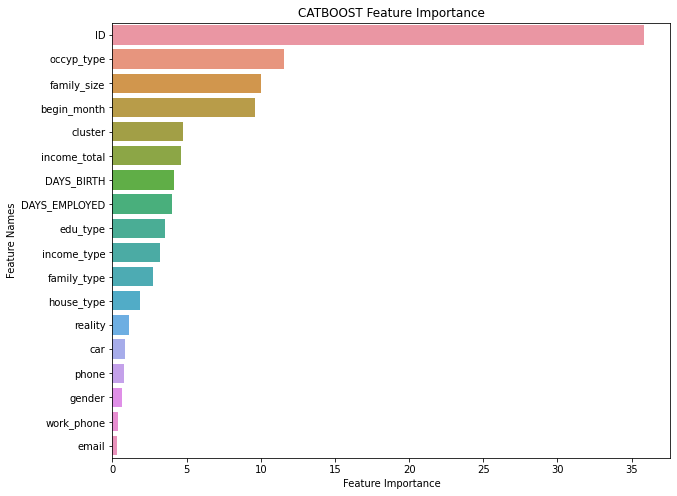

In [45]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

## 모델링3 - Catboost
- 소수점 첫째 자리까지 표현
- 설명력 낮은 변수 제거

### 클러스터링

In [46]:
features = ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']

for df in [train, test]:
    # 제거
    # df.drop( columns = ['email', 'work_phone'], inplace = True)
    # 소수점 첫 째 자리까지
    for feat in features:
        df[feat] = round(df[feat], 1)

In [ ]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

### StandardScale
- categorical_feats는 제외
- 평균 1, 분산 0 : N(1,0)으로 만들어준다.
- 이미 로그변환을 마친 컬럼 제외
- income_total, DAYS_EMOPLOYED, DAYS_BIRTH, begin_month

In [ ]:
for i in categorical:
    numerical_feats.remove(i)

scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
train.head(2)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID,cluster
0,1,1,1,0.408527,1,1,1,1,-0.376803,0.793258,-0.538417,-0.645705,-0.316937,1,-0.214735,-1.317186,1.0,1,0
1,1,1,0,0.825883,1,2,2,2,-1.113878,0.378331,-0.538417,-0.645705,3.155199,2,0.876135,-1.489862,1.0,2,0


In [ ]:
n_est = 2000
seed = 42
n_fold = 20
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115168
0:	learn: 1.0345662	test: 1.0337918	best: 1.0337918 (0)	total: 231ms	remaining: 3m 50s
100:	learn: 0.7055173	test: 0.6550781	best: 0.6550781 (100)	total: 23.1s	remaining: 3m 25s
200:	learn: 0.6886633	test: 0.6526628	best: 0.6524629 (192)	total: 45.7s	remaining: 3m 1s
300:	learn: 0.6727373	test: 0.6507567	best: 0.6507567 (300)	total: 57s	remaining: 2m 12s
400:	learn: 0.6577055	test: 0.6509386	best: 0.6498444 (365)	total: 1m 8s	remaining: 1m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6498443525
bestIteration = 365

Shrink model to first 366 iterations.
CV Log Loss Score: 0.649844

----------------- Fold 1 -----------------

Learning rate set to 0.115168
0:	learn: 1.0346665	test: 1.0327783	best: 1.0327783 (0)	total: 46ms	remaining: 45.9s
100:	learn: 0.7077944	test: 0.6538758	best: 0.6538453 (98)	total: 9.42s	remaining: 1m 23s
200:	learn: 0.6911646	test: 0.6517706	best: 0.6513437 (183)	

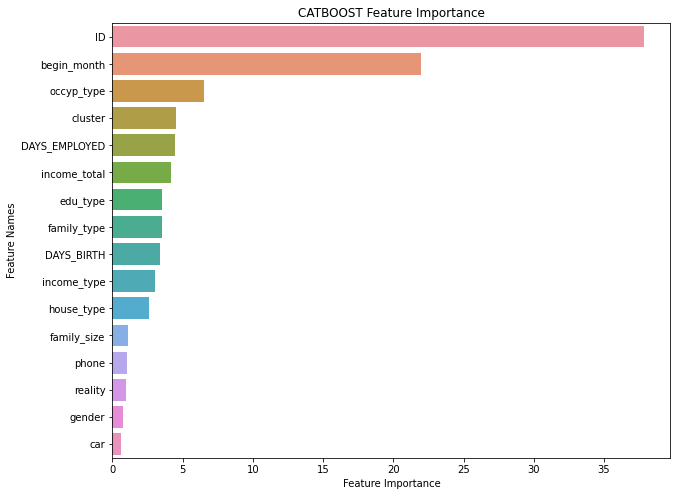

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

- n-fold=20 인 경우 logloss=0.66685
- ID와 begin_month 의 가중치가 높은 것을 확인할 수 있다.
- 샘플링한 것 보다 기존의 자료로 모델링했을 때 성적이 좋은 것을 확인, 같은 데이터로 다른 모델을 이용해보았다.

## 모델링4 - XGBoost
- catboost 모델링을 하기 전까지의 변수 전처리 적용
- ID 파생변수 적용
- 파라미터 튜닝하며 결과 확인

In [ ]:
xgb_params2 = {
    'tree_method' : 'gpu_hist',
    'predictor' : 'gpu_predictor',    
    'objective' : 'multi:softprob',
    'eval_metric' : 'mlogloss',
    'n_estimators' : 5000,
    'max_depth' : 9,
    'min_child_weight' : 3,    
    'learning_rate' : 0.1,    
    'colsample_bytree' : 0.5,    
    'colsample_bylevel' : 0.7,
    'seed' : 1042
}

def train_model(model, train, test, cv = 5):
    tst_preds = []
    vld_preds = []
    feats_importance = np.zeros(test.shape[1])    
    for n, (trn_idx, vld_idx) in enumerate(StratifiedKFold(cv).split(train.drop('credit', axis = 1).values, train['credit'].values)):
        print(f"{n+1}/{cv}번째 폴드 시작..........")        
        X_trn = train.loc[trn_idx, :].drop('credit', axis = 1)
        X_vld = train.loc[vld_idx, :].drop('credit', axis = 1)
        y_trn = train.loc[trn_idx, 'credit'].values
        y_vld = train.loc[vld_idx, 'credit'].values
        
        model.fit(
            X_trn, y_trn,
            eval_set = [(X_trn, y_trn), (X_vld, y_vld)],
            verbose = 500, early_stopping_rounds = 30
        )    
        vld_preds.append(log_loss(y_vld, model.predict_proba(X_vld)))        
        
        tst_pred = model.predict_proba(test)
        tst_preds.append(tst_pred)
        feats_importance += model.feature_importances_                        
        
    feats_importance = feats_importance / cv
    feats_importance = pd.Series(data = feats_importance, index = test.columns)

    print('평균 mlogloss: ', np.mean(vld_preds))
    return tst_preds, feats_importance

In [ ]:
tst_preds_xgb, feat_im_xgb = train_model(XGBClassifier(**xgb_params2), train, test, cv = 15)

1/15번째 폴드 시작..........
[0]	validation_0-mlogloss:1.05809	validation_1-mlogloss:1.05944
[235]	validation_0-mlogloss:0.45341	validation_1-mlogloss:0.71980
2/15번째 폴드 시작..........
[0]	validation_0-mlogloss:1.05846	validation_1-mlogloss:1.05975
[347]	validation_0-mlogloss:0.38454	validation_1-mlogloss:0.67746
3/15번째 폴드 시작..........
[0]	validation_0-mlogloss:1.05758	validation_1-mlogloss:1.05961
[309]	validation_0-mlogloss:0.40231	validation_1-mlogloss:0.69929
4/15번째 폴드 시작..........
[0]	validation_0-mlogloss:1.05820	validation_1-mlogloss:1.05981
[287]	validation_0-mlogloss:0.41475	validation_1-mlogloss:0.71130
5/15번째 폴드 시작..........
[0]	validation_0-mlogloss:1.05790	validation_1-mlogloss:1.06041
[388]	validation_0-mlogloss:0.36732	validation_1-mlogloss:0.68751
6/15번째 폴드 시작..........
[0]	validation_0-mlogloss:1.05785	validation_1-mlogloss:1.05995
[343]	validation_0-mlogloss:0.38207	validation_1-mlogloss:0.70263
7/15번째 폴드 시작..........
[0]	validation_0-mlogloss:1.05770	validation_1-mlogloss:1.0

- 파라미터 튜닝 중 가장 성적이 좋았던 파라미터.
- logloss : 0.701
- catboost에 비해 낮은 성적을 보인다.

## 모델링5 - LGBM

In [ ]:
lgbm_params = {
    'objective': 'multiclass',
    'boosting_type': 'gbdt',
    'eval_metric' : 'logloss',    
    'n_estimators': 10000,
    'early_stopping_round': 100, 
    'max_depth': -1,
    'max_bin': 255,
    'boost_from_average' : False,
    'bagging_freq' : 1,
    'min_data_in_leaf': 40,    
    'learning_rate': 0.02272,    
    'num_leaves': 64,    
    'feature_fraction': 0.89387,
    'bagging_fraction': 0.76326,        
    'seed': 2022,
    'verbose': -1,
    'n_jobs': -1,    
}
def train_model(model, train, test, cv = 5):
    tst_preds = []
    vld_preds = []
    feats_importance = np.zeros(test.shape[1])    
    for n, (trn_idx, vld_idx) in enumerate(StratifiedKFold(cv).split(train.drop('credit', axis = 1).values, train['credit'].values)):
        print(f"{n+1}/{cv}번째 폴드 시작..........")        
        X_trn = train.loc[trn_idx, :].drop('credit', axis = 1)
        X_vld = train.loc[vld_idx, :].drop('credit', axis = 1)
        y_trn = train.loc[trn_idx, 'credit'].values
        y_vld = train.loc[vld_idx, 'credit'].values
        
        model.fit(
            X_trn, y_trn,
            eval_set = [(X_trn, y_trn), (X_vld, y_vld)],
            verbose = 500, early_stopping_rounds = 30
        )    
        vld_preds.append(log_loss(y_vld, model.predict_proba(X_vld)))        
        
        tst_pred = model.predict_proba(test)
        tst_preds.append(tst_pred)
        feats_importance += model.feature_importances_                        
        
    feats_importance = feats_importance / cv
    feats_importance = pd.Series(data = feats_importance, index = test.columns)

    print('mlogloss: ', np.mean(vld_preds))
    return tst_preds, feats_importance

In [ ]:
tst_preds_lgbm, feat_im_lgbm = train_model(LGBMClassifier(**lgbm_params,use_label_encoder=False ), train, test, cv = 20)

- logloss : 0.704
- LightBGM 역시 catboost보다 낮은 성적을 보인다.


- 설명력 높은 변수를 생성하여 CatBoost 모델로 알고리즘 개발로 방향 전환

# Feature set2

## CatBoost 모델1

### 전처리
- 기존의 ID 파생변수 생성 외에 income_total의 가중치 부여

In [ ]:
def numeric(df):
    df['income_weight'] = 1/(df.income_weight)**3
    df['DAYS_BIRTH_cubic'] = df.DAYS_BIRTH**3
    df['DAYS_BIRTH_weight'] = 1/(df.DAYS_BIRTH)**2
    df['income_family'] = df.income_total / df.family_size
    return df

train = numeric(train)
test  = numeric(test)

- 구간화

In [ ]:
def make_bin(df, variable, n):    
    data = df
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable] = pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]
    print(data['%s_bin' % variable], '\n\n')
    return data

train = make_bin(train, 'DAYS_BIRTH', n=10)
test = make_bin(test, 'DAYS_BIRTH', n=10)

train = make_bin(train, 'DAYS_EMPLOYED', n=10)
test = make_bin(test, 'DAYS_EMPLOYED', n=10)

cat_credit=train.credit.astype('int').copy()
train.credit=train.credit.astype('category')

In [ ]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID,income_weight,income_age,income_emp,income_total_dev,income_total_log,DAYS_EMPLOYED_log,DAYS_EMPLOYED_before,DAYS_BIRTH_cubic,DAYS_BIRTH_weight,income_family,DAYS_BIRTH_bin,DAYS_EMPLOYED_bin
0,0,0,0,20,0,1,1,2,13899,4709,0,0,0,12,2,6,1.0,1,1.450273e-32,2.814548e+09,9.535725e+08,2.308172,3.056357,8.457443,9190,2685039411699,5.176460e-09,10.0,0,0
1,0,0,1,24,0,4,0,1,11380,1540,0,0,1,8,3,5,1.0,2,4.350596e-33,2.816550e+09,3.811500e+08,36.231574,3.248435,7.340187,9840,1473760072000,7.721745e-09,8.0,1,1
2,1,1,1,45,4,1,1,1,19087,4434,0,1,0,10,2,22,2.0,3,1.204273e-34,8.589150e+09,1.995300e+09,690.074382,3.828641,8.397283,14653,6953653091503,2.744888e-09,22.5,2,0
3,0,0,1,20,0,4,1,1,15088,2092,0,1,0,15,2,37,0.0,4,1.450273e-32,3.055320e+09,4.236300e+08,2.308172,3.056357,7.646354,12996,3434749161472,4.392752e-09,10.0,3,2
4,0,1,1,15,2,1,1,1,15037,2105,0,0,0,10,2,26,2.0,5,6.551137e-32,2.368328e+09,3.315375e+08,8.884770,2.818398,7.652546,12932,3400036655653,4.422599e-09,7.5,3,2


### n-fold=10

In [ ]:
n_est = 2000
seed = 42
n_fold = 10
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test


In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115043
0:	learn: 1.0358760	test: 1.0343382	best: 1.0343382 (0)	total: 228ms	remaining: 3m 48s
100:	learn: 0.7067372	test: 0.6589122	best: 0.6589122 (100)	total: 16.6s	remaining: 2m 27s
200:	learn: 0.6882969	test: 0.6564202	best: 0.6563252 (175)	total: 29.1s	remaining: 1m 55s
300:	learn: 0.6720172	test: 0.6565387	best: 0.6561792 (261)	total: 43s	remaining: 1m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6561791751
bestIteration = 261

Shrink model to first 262 iterations.
CV Log Loss Score: 0.656179

----------------- Fold 1 -----------------

Learning rate set to 0.115043
0:	learn: 1.0339885	test: 1.0345593	best: 1.0345593 (0)	total: 139ms	remaining: 2m 19s
100:	learn: 0.7096889	test: 0.6587712	best: 0.6587712 (100)	total: 11.1s	remaining: 1m 38s
200:	learn: 0.6906049	test: 0.6569518	best: 0.6567442 (187)	total: 24.9s	remaining: 1m 39s
300:	learn: 0.6747758	test: 0.6583372	best: 0.6566172 (2

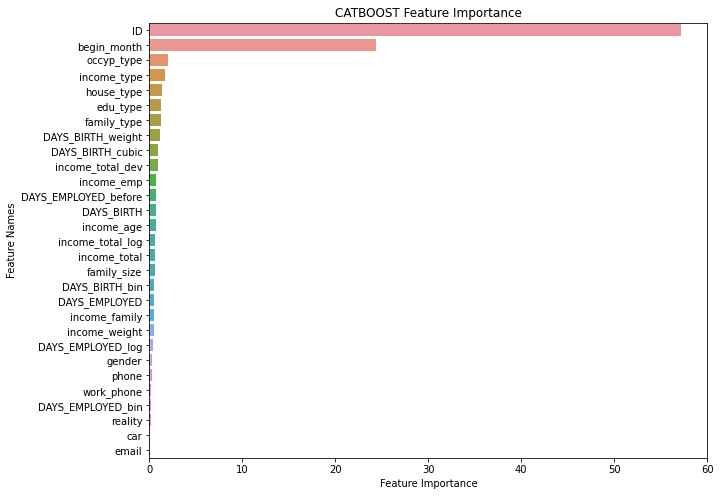

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

### n-fold = 15
- logloss : 0.664093

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
log_loss_avg = []

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0356057	test: 1.0341413	best: 1.0341413 (0)	total: 136ms	remaining: 2m 15s
100:	learn: 0.7058240	test: 0.6422354	best: 0.6421789 (99)	total: 15s	remaining: 2m 13s
200:	learn: 0.6874758	test: 0.6398888	best: 0.6398619 (189)	total: 27.8s	remaining: 1m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6398618659
bestIteration = 189

Shrink model to first 190 iterations.
CV Log Loss Score: 0.639862

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0356100	test: 1.0349051	best: 1.0349051 (0)	total: 145ms	remaining: 2m 25s
100:	learn: 0.7048109	test: 0.6734143	best: 0.6734143 (100)	total: 11.2s	remaining: 1m 39s
200:	learn: 0.6868747	test: 0.6714541	best: 0.6710867 (198)	total: 23.7s	remaining: 1m 34s
300:	learn: 0.6703758	test: 0.6710550	best: 0.6705161 (280)	total: 36.3s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

b

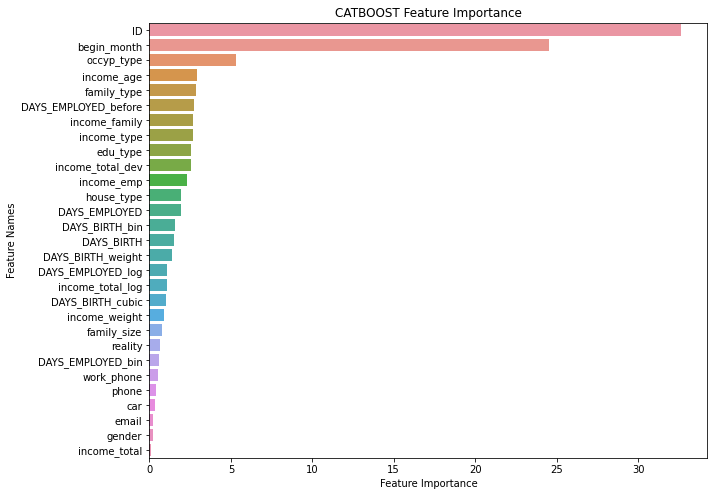

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

- ID 의 설명력 증가

## CatBoost 모델2
- 설명력이 부족했던 변수를 제거
- 클러스터링 / 정규화 진행
- CrossValidation Parameter

In [ ]:
col = ['income_total', 'work_phone', 'email', 'DAYS_EMPLOYED_bin']
for df in [train, test]:
    df.drop(columns=col, inplace=True)

In [ ]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [ ]:
cat_col = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID',
            'DAYS_EMPLOYED_log', 'income_total_log', 'income_total', 'work_phone', 'email',
            'DAYS_EMPLOYED_bin' ]

In [ ]:
for feat in cat_col:
    numerical_feats.remove(feat)

scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

### n-fold = 10
- log loss : 0.669396


In [ ]:
n_fold = 10
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
log_loss_avg = []

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115043
0:	learn: 1.0358741	test: 1.0342023	best: 1.0342023 (0)	total: 300ms	remaining: 4m 59s
100:	learn: 0.7059414	test: 0.6589508	best: 0.6589181 (96)	total: 12s	remaining: 1m 46s
200:	learn: 0.6860390	test: 0.6577139	best: 0.6572876 (147)	total: 24.5s	remaining: 1m 37s
300:	learn: 0.6677530	test: 0.6564003	best: 0.6562299 (297)	total: 38s	remaining: 1m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6562298762
bestIteration = 297

Shrink model to first 298 iterations.
CV Log Loss Score: 0.656230

----------------- Fold 1 -----------------

Learning rate set to 0.115043
0:	learn: 1.0378588	test: 1.0390255	best: 1.0390255 (0)	total: 98.1ms	remaining: 1m 37s
100:	learn: 0.7081581	test: 0.6613689	best: 0.6612743 (90)	total: 11.5s	remaining: 1m 42s
200:	learn: 0.6890117	test: 0.6593983	best: 0.6589734 (187)	total: 24.2s	remaining: 1m 36s
300:	learn: 0.6704032	test: 0.6602036	best: 0.6586399 (241)

### n_fold = 15
- Log Loss : 0.665395

In [ ]:
n_fold = 15
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
log_loss_avg = []

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')





----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0348881	test: 1.0336665	best: 1.0336665 (0)	total: 144ms	remaining: 2m 23s
100:	learn: 0.7056921	test: 0.6419577	best: 0.6419425 (95)	total: 11.5s	remaining: 1m 41s
200:	learn: 0.6868178	test: 0.6395174	best: 0.6395174 (200)	total: 30.9s	remaining: 2m 2s
300:	learn: 0.6691743	test: 0.6396400	best: 0.6391660 (275)	total: 45.3s	remaining: 1m 45s
400:	learn: 0.6529950	test: 0.6394316	best: 0.6387545 (381)	total: 58.3s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6387544707
bestIteration = 381

Shrink model to first 382 iterations.
CV Log Loss Score: 0.638754

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0347871	test: 1.0340401	best: 1.0340401 (0)	total: 136ms	remaining: 2m 16s
100:	learn: 0.7041998	test: 0.6733554	best: 0.6731291 (82)	total: 11.6s	remaining: 1m 43s
200:	learn: 0.6859933	test: 0.6712444	best: 0.6711024 (14

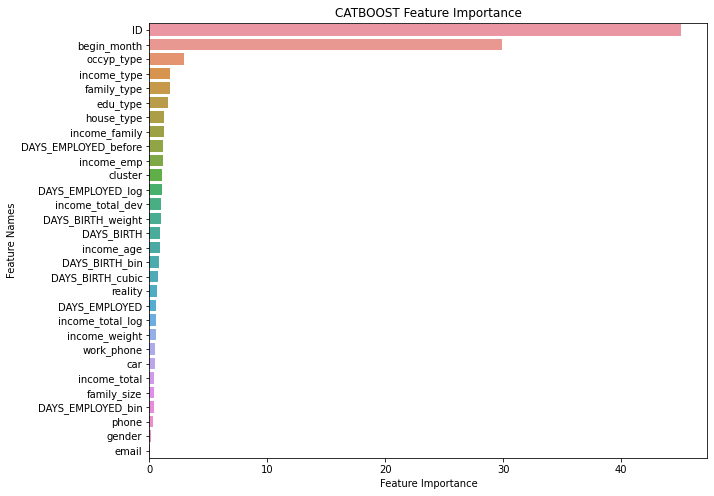

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

- occyp_type 
    - 직업 분류의 설명력 증가.

# Feature set3

- CatBoost는 Categorical feature의 중요도가 높다고 판단
    - gender, car, reality 등 8개 Category 변수를 조합
        - 파생변수 'G_C_R' , 'I_O_E' , 'F_H' 생성
- Optuna Library를 이용하여 최적의 CatBoost HyperParameter 찾기


In [ ]:
def categoric(df):
# 1. 의미없는 변수 제거 : index, FLAG_MOBIL, child_num
    df.drop(['index', 'FLAG_MOBIL', 'child_num'], axis=1, inplace = True)

# 2. 이상치 처리
    df = df[ ( df['family_size'] <= 7 ) ]
    df = df.reset_index(drop=True)

# 3. 결측치 처리
    df.loc[ (df.occyp_type.isna() == True) & (df.DAYS_EMPLOYED > 0) & (df.income_type == 'Pensioner') , 'occyp_type' ] = 'retiree'
    df['DAYS_EMPLOYED'] = df[ 'DAYS_EMPLOYED' ].map(lambda x: 0 if x>0 else x)
    df.occyp_type.fillna('No response', inplace=True) 

# 4. 새로운 변수 ID열 생성 : 한 사람이 다수의 카드를 발급 받았을 경우
    df['ID'] = \
    df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

# 5. gender+car+reality 변수 : 자산
    df['G_C_R'] = \
    df['gender'] + '_' + df['car'] + '_' + df['reality']

# 6. income_type+occyp_type+edu_type 변수 : 경제 활동
    df['I_O_E'] = \
    df['income_type'] + '_' + df['occyp_type'] + '_' + df['edu_type']

# 7. family_type+house_type : 가정 환경
    df['F_H'] = \
    df['family_type'] + '_' + df['house_type']

    return df

train = categoric(train)
test  = categoric(test)

In [ ]:
def numeric(df):
# 1. 음수자료를 양수로 변환
    feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
    for feat in feats:
        df[feat] = np.abs(df[feat])

# 3. income_total 가중치 (numerical EDA 참조)
    df['income_weight']=df.income_total**2
    df['income_age']=df.income_total*df.DAYS_BIRTH
    df['income_emp']=df.income_total*df.DAYS_EMPLOYED
    df['income_total'] = df['income_total']/10000
    df['income_total_dev'] = (df['income_total'] - df['income_total'].mean())**2 # 편차제곱
    df['income_total_log'] = df['income_total'].apply(np.log1p)                  # 로그변환

# 4. DAYS_EMPLOYED 가중치
    df['DAYS_EMPLOYED_log'] = df['DAYS_EMPLOYED'].apply(np.log1p) # 로그 변환
    df['DAYS_EMPLOYED_before'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED'] # 로그 변환
    
# 5. type 변환
    df.income_total = df.income_total.astype(int)
    df.family_size = df.family_size.astype(int)
    df.begin_month = df.begin_month.astype(int)

# 6. 파생변수
    df['income_weight'] = 1/(df.income_weight)**3
    df['DAYS_BIRTH_cubic'] = df.DAYS_BIRTH**3
    df['DAYS_BIRTH_weight'] = 1/(df.DAYS_BIRTH)**2
    df['income_family'] = df.income_total / df.family_size
    return df

train = numeric(train)
test  = numeric(test)

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [ ]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

## Optuna

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-03-03 16:30:08,048] A new study created in memory with name: cat_parameter_opt


0:	learn: 1.0828775	test: 1.0828775	test1: 1.0830258	best: 1.0830258 (0)	total: 82.5ms	remaining: 10m 26s
100:	learn: 0.8815088	test: 0.8815088	test1: 0.8873741	best: 0.8873741 (100)	total: 2.29s	remaining: 2m 50s


[I 2022-03-03 16:30:11,830] Trial 0 finished with value: 0.8873625541902477 and parameters: {'learning_rate': 0.03574712922600244, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.8873625541902477.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8873625542
bestIteration = 108

Shrink model to first 109 iterations.
0:	learn: 0.9929890	test: 0.9929890	test1: 0.9946005	best: 0.9946005 (0)	total: 137ms	remaining: 6m 39s
100:	learn: 0.7011239	test: 0.7116694	test1: 0.7869701	best: 0.7869701 (100)	total: 12.9s	remaining: 5m 59s
200:	learn: 0.6216065	test: 0.6395257	test1: 0.7690058	best: 0.7690058 (200)	total: 25.6s	remaining: 5m 44s
300:	learn: 0.5635082	test: 0.5884329	test1: 0.7598308	best: 0.7598308 (300)	total: 38.5s	remaining: 5m 33s


[I 2022-03-03 16:31:00,777] Trial 1 finished with value: 0.7563750625454062 and parameters: {'learning_rate': 0.2708160864249968, 'bagging_temperature': 21.368329072358772, 'n_estimators': 2911, 'max_depth': 6, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226, 'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.7563750625454062.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7563750625
bestIteration = 343

Shrink model to first 344 iterations.
0:	learn: 1.0865207	test: 1.0865820	test1: 1.0863963	best: 1.0863963 (0)	total: 643ms	remaining: 54m 40s
100:	learn: 0.8096701	test: 0.7307479	test1: 0.7908628	best: 0.7908628 (100)	total: 1m 36s	remaining: 1h 19m 50s
200:	learn: 0.7607791	test: 0.6315574	test1: 0.7373602	best: 0.7373602 (200)	total: 3m 4s	remaining: 1h 14m 55s
300:	learn: 0.7369826	test: 0.5817997	test1: 0.7139311	best: 0.7139311 (300)	total: 4m	remaining: 1h 4m 4s
400:	learn: 0.7130936	test: 0.5360607	test1: 0.6954358	best: 0.6954358 (400)	total: 5m 54s	remaining: 1h 9m 13s
500:	learn: 0.5846472	test: 0.4804680	test1: 0.6754460	best: 0.6754031 (499)	total: 10m 42s	remaining: 1h 38m 21s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6735830503
bestIteration = 543

Shrink model to first 544 iterations.


[I 2022-03-03 16:47:06,947] Trial 2 finished with value: 0.6735830502821478 and parameters: {'learning_rate': 0.027010527749605478, 'bagging_temperature': 0.2920433847181412, 'n_estimators': 5105, 'max_depth': 14, 'random_strength': 20, 'colsample_bylevel': 0.708540663048167, 'l2_leaf_reg': 1.7776512920172654e-05, 'min_child_samples': 9, 'max_bin': 382, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.6735830502821478.


0:	learn: 1.0004786	test: 1.0004786	test1: 1.0008649	best: 1.0008649 (0)	total: 21ms	remaining: 2m 53s


[I 2022-03-03 16:47:08,684] Trial 3 finished with value: 0.8836591024581331 and parameters: {'learning_rate': 0.2521267904777921, 'bagging_temperature': 72.86653737491046, 'n_estimators': 8276, 'max_depth': 7, 'random_strength': 9, 'colsample_bylevel': 0.8105398159072941, 'l2_leaf_reg': 1.3210173287250643e-05, 'min_child_samples': 16, 'max_bin': 349, 'od_type': 'Iter'}. Best is trial 2 with value: 0.6735830502821478.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8836591025
bestIteration = 20

Shrink model to first 21 iterations.
0:	learn: 1.0877152	test: 1.0878579	test1: 1.0878720	best: 1.0878720 (0)	total: 301ms	remaining: 19m 6s
100:	learn: 0.7720632	test: 0.6972826	test1: 0.7685879	best: 0.7685879 (100)	total: 24.5s	remaining: 15m
200:	learn: 0.7155331	test: 0.5972533	test1: 0.7209561	best: 0.7209561 (200)	total: 49.3s	remaining: 14m 43s
300:	learn: 0.6780834	test: 0.5567816	test1: 0.7055827	best: 0.7055827 (300)	total: 1m 18s	remaining: 15m 18s
400:	learn: 0.6372230	test: 0.5257345	test1: 0.6951886	best: 0.6951886 (400)	total: 1m 49s	remaining: 15m 30s
500:	learn: 0.5761083	test: 0.4995616	test1: 0.6876373	best: 0.6876373 (500)	total: 2m 23s	remaining: 15m 46s
600:	learn: 0.5173167	test: 0.4764607	test1: 0.6834759	best: 0.6834233 (599)	total: 2m 56s	remaining: 15m 42s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6834232539
bestIteration = 599

Shrink

[I 2022-03-03 16:50:17,198] Trial 4 finished with value: 0.6834232539376278 and parameters: {'learning_rate': 0.024112898115291985, 'bagging_temperature': 4.467752817973908, 'n_estimators': 3805, 'max_depth': 10, 'random_strength': 55, 'colsample_bylevel': 0.5109126733153162, 'l2_leaf_reg': 2.9087842986659113e-05, 'min_child_samples': 79, 'max_bin': 482, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.6735830502821478.


0:	learn: 1.0074444	test: 1.0074493	test1: 1.0082218	best: 1.0082218 (0)	total: 131ms	remaining: 6m 3s
100:	learn: 0.7109815	test: 0.4815845	test1: 0.6780513	best: 0.6780186 (99)	total: 7.03s	remaining: 3m 5s


[I 2022-03-03 16:50:29,117] Trial 5 finished with value: 0.677488080938512 and parameters: {'learning_rate': 0.22999586428143728, 'bagging_temperature': 0.022592797420156956, 'n_estimators': 2764, 'max_depth': 4, 'random_strength': 32, 'colsample_bylevel': 0.6332063738136893, 'l2_leaf_reg': 8.147757462899138e-06, 'min_child_samples': 84, 'max_bin': 307, 'od_type': 'Iter'}. Best is trial 2 with value: 0.6735830502821478.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6774880809
bestIteration = 115

Shrink model to first 116 iterations.
0:	learn: 1.0863772	test: 1.0883014	test1: 1.0907096	best: 1.0907096 (0)	total: 11.1s	remaining: 5h 7m 38s
100:	learn: 0.5176032	test: 0.5593905	test1: 0.7932242	best: 0.7932242 (100)	total: 20m 4s	remaining: 5h 12m 2s
200:	learn: 0.3293935	test: 0.3879037	test1: 0.7750893	best: 0.7733051 (165)	total: 34m 29s	remaining: 4h 12m 12s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7733051342
bestIteration = 165

Shrink model to first 166 iterations.


[I 2022-03-03 17:25:00,676] Trial 6 finished with value: 0.7733051342289939 and parameters: {'learning_rate': 0.016149614799999188, 'bagging_temperature': 16.172900811143155, 'n_estimators': 1671, 'max_depth': 16, 'random_strength': 77, 'colsample_bylevel': 0.5192294089205034, 'l2_leaf_reg': 1.7560829253683595e-07, 'min_child_samples': 83, 'max_bin': 412, 'od_type': 'Iter'}. Best is trial 2 with value: 0.6735830502821478.


0:	learn: 1.0929256	test: 1.0929256	test1: 1.0928710	best: 1.0928710 (0)	total: 16.5ms	remaining: 33.7s
100:	learn: 0.8844129	test: 0.8677947	test1: 0.8819082	best: 0.8819082 (100)	total: 38.9s	remaining: 12m 42s
200:	learn: 0.8361761	test: 0.7762750	test1: 0.8274152	best: 0.8274152 (200)	total: 1m 30s	remaining: 14m
300:	learn: 0.8039787	test: 0.7030853	test1: 0.7909375	best: 0.7909375 (300)	total: 2m 46s	remaining: 16m 11s
400:	learn: 0.7801718	test: 0.6431539	test1: 0.7646889	best: 0.7646889 (400)	total: 4m 10s	remaining: 17m 10s
500:	learn: 0.7670629	test: 0.6168991	test1: 0.7528197	best: 0.7528174 (497)	total: 5m 9s	remaining: 15m 56s
600:	learn: 0.7562842	test: 0.5942632	test1: 0.7438316	best: 0.7438316 (600)	total: 6m 30s	remaining: 15m 39s
700:	learn: 0.7477095	test: 0.5746262	test1: 0.7362578	best: 0.7362578 (700)	total: 7m 16s	remaining: 13m 56s
800:	learn: 0.7372998	test: 0.5581224	test1: 0.7288648	best: 0.7288648 (800)	total: 8m 23s	remaining: 13m 1s
900:	learn: 0.7209885	t

[I 2022-03-03 17:48:02,592] Trial 7 finished with value: 0.6846144068718785 and parameters: {'learning_rate': 0.012863908101989912, 'bagging_temperature': 0.27155819552829413, 'n_estimators': 2042, 'max_depth': 15, 'random_strength': 62, 'colsample_bylevel': 0.5985388149115896, 'l2_leaf_reg': 1.9161149250778487e-06, 'min_child_samples': 34, 'max_bin': 297, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.6735830502821478.


0:	learn: 1.0167233	test: 1.0167285	test1: 1.0170722	best: 1.0170722 (0)	total: 31.8ms	remaining: 1m 5s
100:	learn: 0.3006564	test: 0.4153692	test1: 0.7344807	best: 0.6892745 (69)	total: 1m 1s	remaining: 19m 58s


[I 2022-03-03 17:49:08,773] Trial 8 finished with value: 0.6892744801094646 and parameters: {'learning_rate': 0.20441878352493792, 'bagging_temperature': 0.7742116473996251, 'n_estimators': 2076, 'max_depth': 13, 'random_strength': 76, 'colsample_bylevel': 0.7367663185416977, 'l2_leaf_reg': 2.3131305726837285e-05, 'min_child_samples': 52, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.6735830502821478.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6892744801
bestIteration = 69

Shrink model to first 70 iterations.
0:	learn: 1.0922062	test: 1.0922057	test1: 1.0922210	best: 1.0922210 (0)	total: 37.1ms	remaining: 4m 9s
100:	learn: 0.8869543	test: 0.8839723	test1: 0.8889405	best: 0.8889405 (100)	total: 6.22s	remaining: 6m 48s
200:	learn: 0.8440065	test: 0.7989567	test1: 0.8358204	best: 0.8358204 (200)	total: 12.8s	remaining: 6m 56s
300:	learn: 0.8181507	test: 0.7278864	test1: 0.7984220	best: 0.7984220 (300)	total: 23.6s	remaining: 8m 22s
400:	learn: 0.8040011	test: 0.6831164	test1: 0.7779502	best: 0.7779502 (400)	total: 37s	remaining: 9m 43s
500:	learn: 0.7898408	test: 0.6460959	test1: 0.7601807	best: 0.7601807 (499)	total: 52.2s	remaining: 10m 48s
600:	learn: 0.7788907	test: 0.6206618	test1: 0.7475205	best: 0.7475205 (600)	total: 1m 6s	remaining: 11m 16s
700:	learn: 0.7687870	test: 0.5978980	test1: 0.7364983	best: 0.7364983 (700)	total: 1m 21s	remaining: 11m 40s
80

[I 2022-03-03 17:52:01,020] Trial 9 finished with value: 0.6717837325495211 and parameters: {'learning_rate': 0.01443340240633889, 'bagging_temperature': 0.0133572404119741, 'n_estimators': 6728, 'max_depth': 8, 'random_strength': 51, 'colsample_bylevel': 0.9445398843556558, 'l2_leaf_reg': 7.486273952174759e-06, 'min_child_samples': 44, 'max_bin': 427, 'od_type': 'IncToDec'}. Best is trial 9 with value: 0.6717837325495211.


Best Score: 0.6717837325495211
Best trial {'learning_rate': 0.01443340240633889, 'bagging_temperature': 0.0133572404119741, 'n_estimators': 6728, 'max_depth': 8, 'random_strength': 51, 'colsample_bylevel': 0.9445398843556558, 'l2_leaf_reg': 7.486273952174759e-06, 'min_child_samples': 44, 'max_bin': 427, 'od_type': 'IncToDec'}


In [ ]:
X = train.drop(['credit'],axis=1)
y = train['credit']
X_test = test.copy()

In [ ]:
def objective(trial):
  param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }

  X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)
  
  cat_features =['gender','car','reality','income_type', 'edu_type', 'family_type',
                 'house_type', 'occyp_type', 'ID', 'F_H']
  cat = CatBoostClassifier(**param)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  cat_pred = cat.predict_proba(X_valid)
  log_score = log_loss(y_valid, cat_pred)

  return log_score

In [ ]:
Best_trial = {'learning_rate': 0.01443340240633889,
 'bagging_temperature': 0.0133572404119741,
 'n_estimators': 6728,
 'max_depth': 8,
 'random_strength': 51,
 'colsample_bylevel': 0.9445398843556558,
 'l2_leaf_reg': 7.486273952174759e-06,
 'min_child_samples': 44,
 'max_bin': 427,
 'od_type': 'IncToDec'}

In [ ]:
category = ['gender','car','reality','income_type','edu_type',
            'family_type','house_type','occyp_type','ID',
            'G_C_R','I_O_E','F_H']
for i in category:
    numerical_feats.remove(i)

In [ ]:
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]

for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['gender','car','reality','income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type',
            'ID','G_C_R','F_H']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
  
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier(**study.best_params)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
    
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

0:	learn: 1.0921875	test: 1.0922084	best: 1.0922084 (0)	total: 140ms	remaining: 15m 40s
100:	learn: 0.8799558	test: 0.8738823	best: 0.8738823 (100)	total: 17s	remaining: 18m 37s
200:	learn: 0.8411028	test: 0.8220687	best: 0.8220687 (200)	total: 32.9s	remaining: 17m 48s
300:	learn: 0.8216370	test: 0.7937423	best: 0.7937423 (300)	total: 46.7s	remaining: 16m 36s
400:	learn: 0.8039316	test: 0.7682281	best: 0.7682281 (400)	total: 1m 2s	remaining: 16m 25s
500:	learn: 0.7893795	test: 0.7490824	best: 0.7490824 (500)	total: 1m 19s	remaining: 16m 22s
600:	learn: 0.7778911	test: 0.7329813	best: 0.7329813 (600)	total: 1m 34s	remaining: 16m 7s
700:	learn: 0.7673642	test: 0.7192914	best: 0.7192914 (700)	total: 1m 54s	remaining: 16m 23s
800:	learn: 0.7439370	test: 0.6906759	best: 0.6906759 (800)	total: 2m 12s	remaining: 16m 19s
900:	learn: 0.7200614	test: 0.6620279	best: 0.6620279 (900)	total: 2m 33s	remaining: 16m 31s
1000:	learn: 0.7033791	test: 0.645840

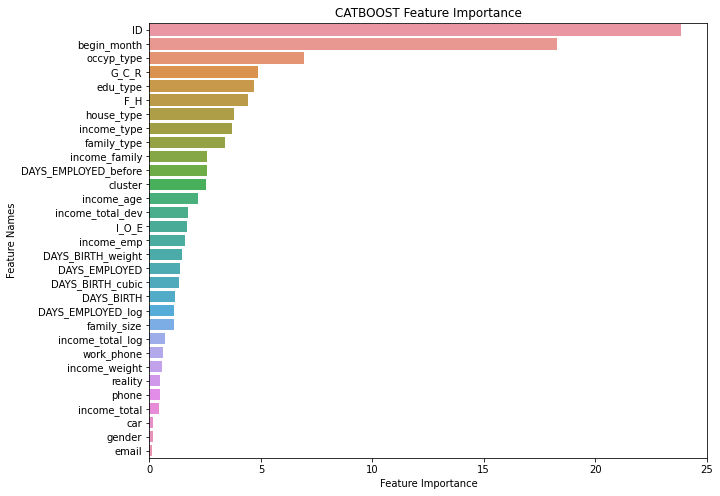

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

- Log Loss: 0.662465

In [ ]:
sample_sub.iloc[:, 1:] = cat_pred_test

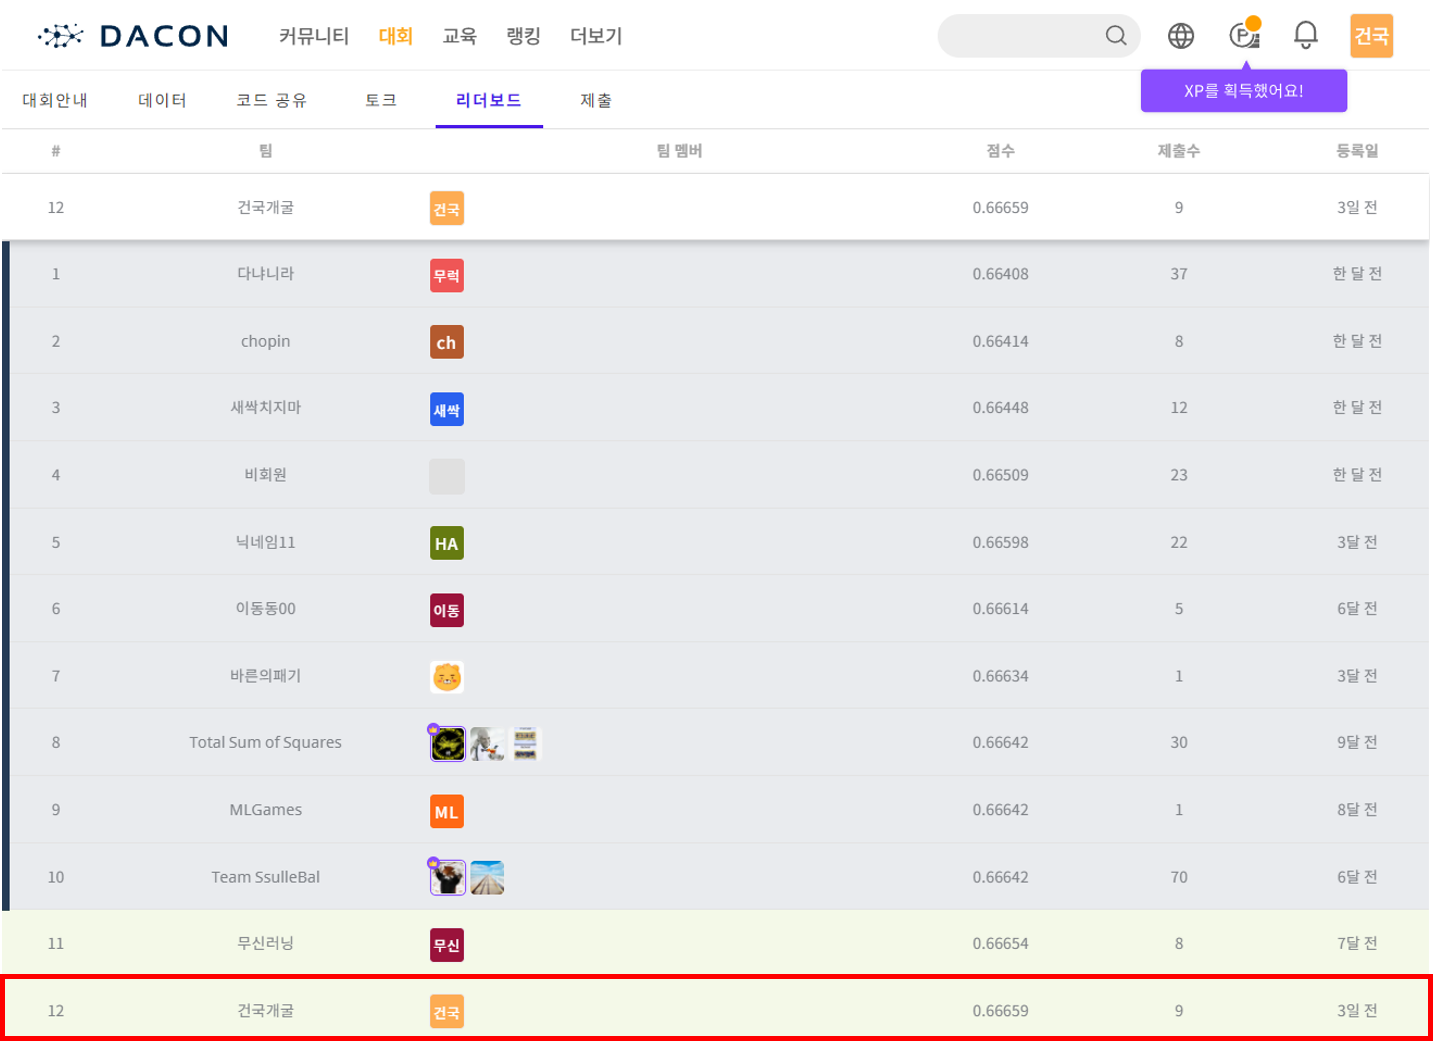

- 제출 점수 : 0.66659

# 기대효과 및 개발 후기
- 다양한 변수를 만들고 여러 모델을 사용하며 알고리즘 공부에 도움이 되었습니다. 결국 각 모델마다 설명력이 높은 변수를 만들어내고, 좋은 성적이 나오도록 파라미터를 튜닝하는 것이 중요했습니다. 
- 이 데이터의 경우 결론적으로 catboost 모델이 가장 좋은 결과를 보였는데 그에 맞게 categorical 파생 변수를 생성한 것이 좋은 성적을 도출하는데 큰 역할을 한 것 같습니다. 